In [8]:
import scanpy as sc
from genevector.data import GeneVectorDataset
from genevector.model import GeneVector
from genevector.embedding import GeneEmbedding, CellEmbedding

import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import numpy
from scipy.sparse import csr_matrix, find
import operator
import itertools
import collections
import sys
import os
import matplotlib.pyplot as plt

import gc
import scipy
import pandas
import tqdm
import collections

In [9]:
adata = sc.read("TICA.h5ad")

In [10]:
dataset = GeneVectorDataset(adata)

Loading Expression.
Indexing expression.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2630673/2630673 [00:01<00:00, 1921378.77it/s]


Finished.


In [11]:
embed = GeneEmbedding("tica.vec", dataset, vector="average")
print(embed.compute_similarities("CD3D")[:10])

Loading average of 1st and 2nd weights.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3326172.88it/s]

    Gene  Similarity
0   CD3D    1.000000
1   CD3G    0.919153
2   IL32    0.905473
3    CD2    0.901621
4    LCK    0.899897
5   TRAC    0.897106
6   CD52    0.893137
7  ITM2A    0.889803
8   CD3E    0.887146
9  SYNE2    0.886308


In [12]:
cembed = CellEmbedding(dataset, embed)
adata = cembed.get_adata()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2630673/2630673 [00:04<00:00, 579912.18it/s]


Generating Cell Vectors.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22871/22871 [00:01<00:00, 17952.35it/s]


Found 0 Cells with No Counts.
Finished.
Loading embedding in X_genevector.
Running Scanpy neighbors and umap.


In [13]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.9.0 pandas==1.5.1 scikit-learn==1.2.1 statsmodels==0.13.5 python-igraph==0.9.11 pynndescent==0.5.8


/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


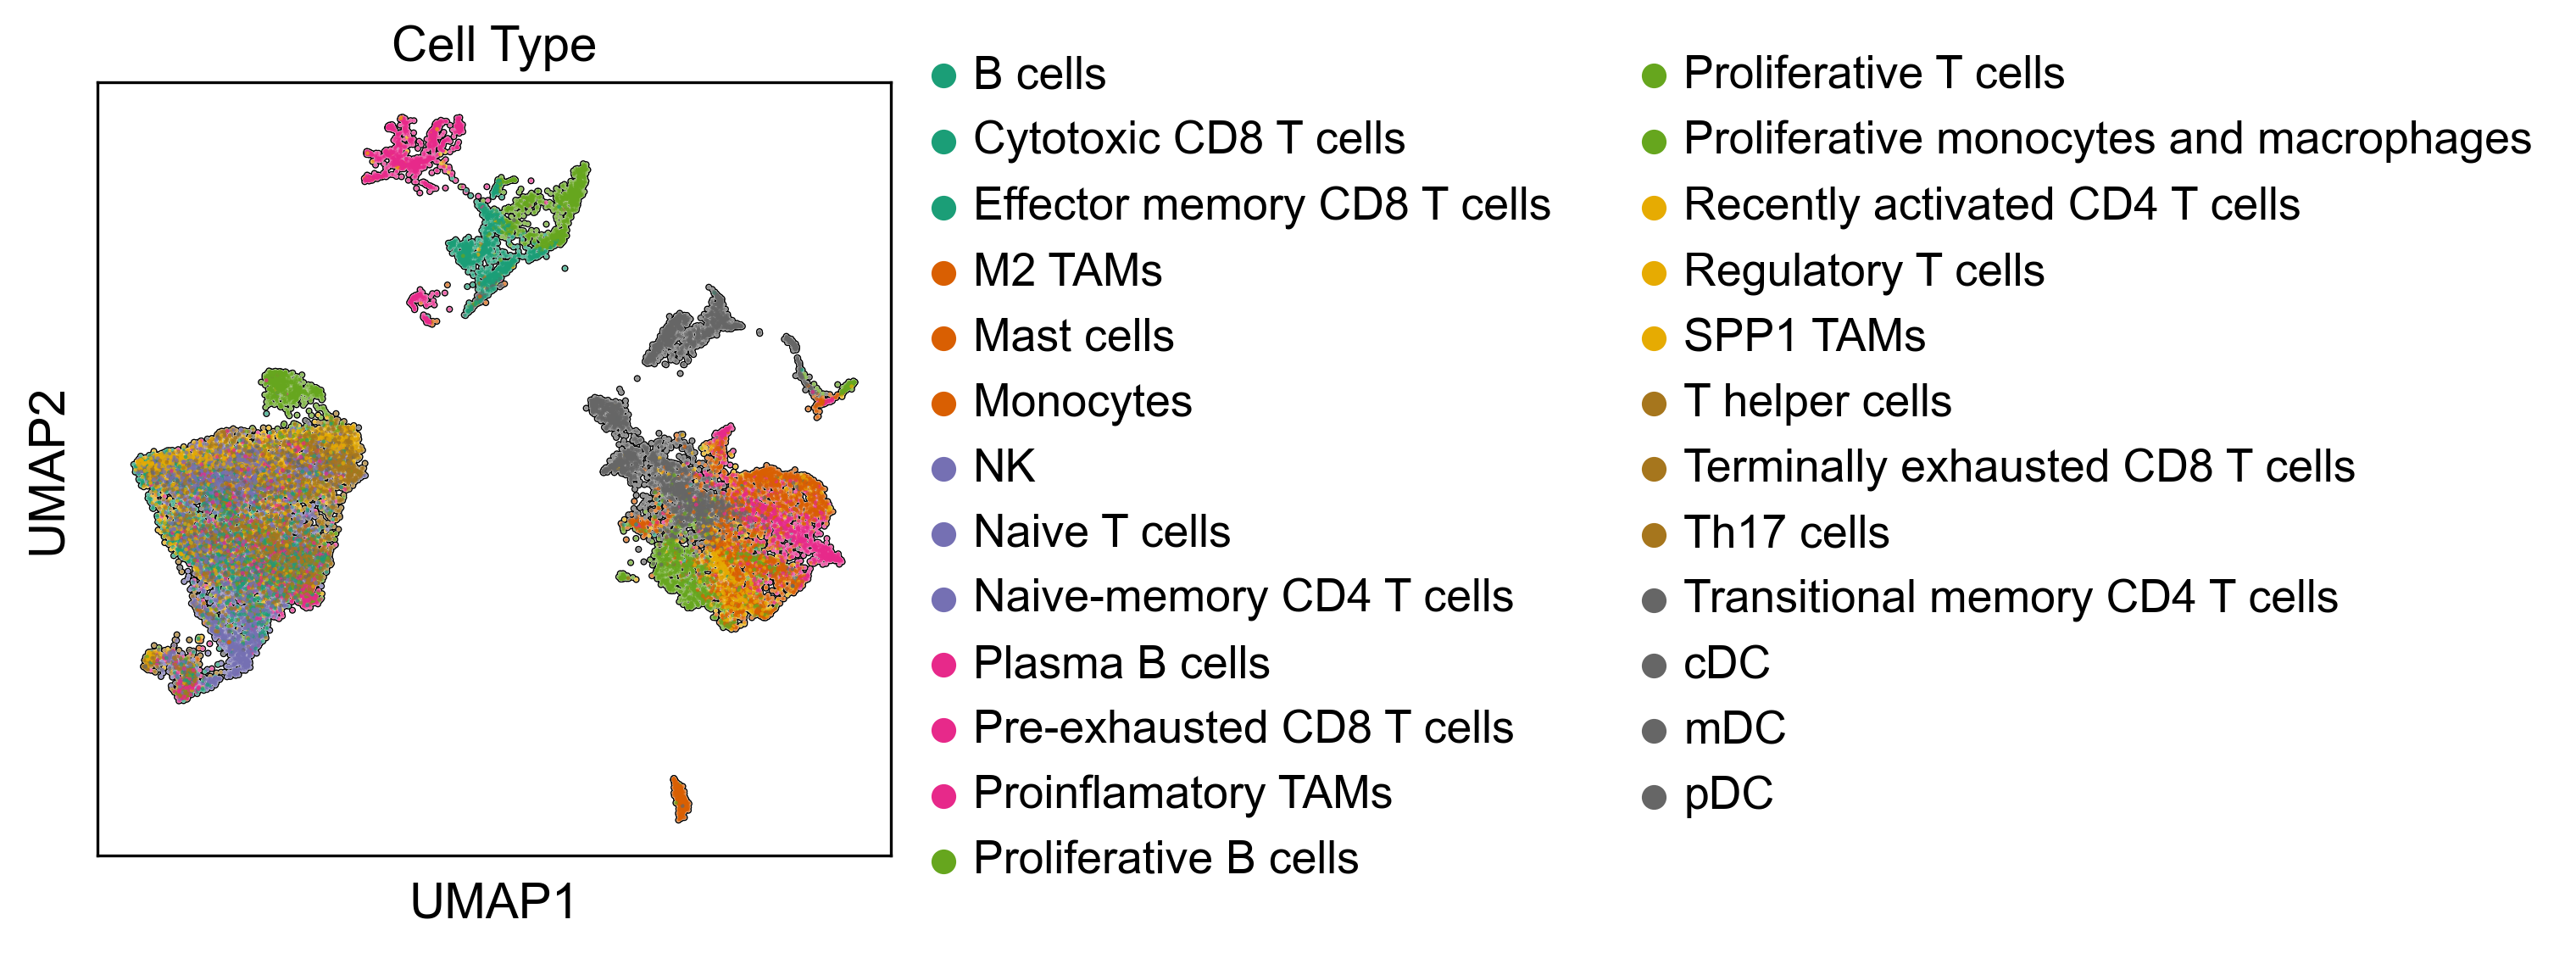

In [ ]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=150, facecolor='white')
sc.pl.umap(adata,palette="Dark2",color=["cell_type"],title="Cell Type",
           add_outline=True)

In [15]:
ct2 = []
for x in adata.obs["cell_type"]:
    if "T " in x:
        ct2.append("T Cell")
    elif "mDC" in x or "cDC" in x or "pDC" in x:
        ct2.append("Myeloid")
    elif "mono" in x.lower():
        ct2.append("Myeloid")
    elif "TAM" in x:
        ct2.append("Myeloid")
    elif "B " in x:
        ct2.append("B/Plasma")
    elif "NK" in x:
        ct2.append("T Cell")
    elif "Th" in x:
        ct2.append("T Cell")
    elif "Mast" in x:
        ct2.append("Myeloid")
    else:
        ct2.append(x)
print(set(ct2))
adata.obs["coarse_cell_type_3class"] = ct2

sc.pl.umap(adata,palette="Dark2",color=["coarse_cell_type_3class"],title="Cell Type",
           add_outline=True)

{'B/Plasma', 'Myeloid', 'T Cell'}


/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [16]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from scipy.special import softmax
from numpy.linalg import inv

def generate_weighted_vector(self, genes, markers, weights):
    vector = []
    weight = []
    for gene, vec in zip(self.genes, self.vector):
        if gene in genes and gene in weights:
            vector.append(weights[gene] * numpy.array(vec))
        if gene not in genes and gene in markers and gene in weights:
            vector.append(list(weights[gene] * numpy.negative(numpy.array(vec))))
    return list(numpy.sum(vector, axis=0))

def generate_marker_matrix(self,adata,up_phenotype_markers,down_phenotype_markers):
    markers = []
    for _, genes in up_phenotype_markers.items():
        markers += genes
    for _, genes in down_phenotype_markers.items():
        markers += genes
    markers = list(set(markers))
    print(markers)
    matrix = []
    adata = self.context.adata.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    genes = adata.var.index.tolist()
    barcodes = adata.obs.index.tolist()
    for cell in tqdm.tqdm(adata.obs.index.tolist()):
        vectors = []
        weights = []
        for gene, weight in self.normalized_expression[cell].items():
            if gene in markers and gene in embed.embeddings:
                weights.append(weight)
                vectors.append(embed.embeddings[gene])
        weights = numpy.array(weights)
        if len(weights) == 0.:
            matrix.append(self.dataset_vector)
        else:
            matrix.append(numpy.average(vectors,axis=0,weights=weights))
    return matrix

def phenotype_probability(self, adata, up_phenotype_markers, down_phenotype_markers, target_col="genevector"):
    mapped_components = dict(zip(list(self.data.keys()),self.matrix))
    adata = adata[list(self.data.keys())]
    probs = dict()
    
    bdata = adata.copy()
#     sc.pp.normalize_total(bdata)
#     sc.pp.log1p(bdata)
    nmat=bdata.X.todense().tolist()

    amarkers = []
    for _, genes in up_phenotype_markers.items():
        amarkers += genes
    for _, genes in down_phenotype_markers.items():
        amarkers += genes
    amarkers = list(set(amarkers))
    dataset_vector = numpy.average(self.matrix,axis=0)
    ndmat = dict(zip(bdata.obs.index.tolist(), nmat))
    self.normalized_expression = dict()
    for bc, exp in ndmat.items():
        exp = list(exp)
        self.normalized_expression[bc] = dict(zip(bdata.var.index.tolist(),exp))
    for pheno, markers in up_phenotype_markers.items():
        dists = []
        for x in tqdm.tqdm(adata.obs.index):
            weights = self.normalized_expression[x]
            try:
                vector = generate_weighted_vector(self.embed, markers, amarkers, weights)
                dvec = numpy.subtract(mapped_components[x], dataset_vector)
                dist = 1. - distance.cosine(mapped_components[x], numpy.array(vector))
                dists.append(dist)
            except Exception as e:
                print(e)
                dists.append(0.)
        probs[pheno] = dists
    distribution = []
    celltypes = []
    for k, v in probs.items():
        distribution.append(v)
        celltypes.append(k)
    if distribution.count(0.) == len(distribution):
        print("Bad")
    distribution = list(zip(*distribution))
    classif = []
    probabilities = []
    probabilities = softmax(numpy.array(distribution),axis=1)
    for ct in probabilities:
        assign = celltypes[numpy.argmax(ct)]
        classif.append(assign)
    res = {"distances":distribution, "order":celltypes, "probabilities":probabilities}
    barcode_to_label = dict(zip(list(self.data.keys()), res["probabilities"]))
    ct = []
    probs = collections.defaultdict(list)
    for x in adata.obs.index:
        ctx = res["order"][numpy.argmax(barcode_to_label[x])]
        ct.append(ctx)
        for ph, pb in zip(res["order"],barcode_to_label[x]):
            probs[ph].append(pb)
    adata.obs[target_col] = ct

    def load_predictions(adata,probs):
        for ph in probs.keys():
            print(ph)
            adata.obs[ph+" Pseudo-probability"] = probs[ph]
        return adata
    adata = load_predictions(adata,probs)
    return adata



In [17]:
embed.compute_similarities("C1QB")[:20]

Gene  Similarity
0       C1QB    1.000000
1       C1QA    0.905184
2       C1QC    0.879298
3     FCGR2A    0.861677
4     FCER1G    0.856858
5      MS4A7    0.855050
6       NPC2    0.849942
7        GRN    0.844345
8       CD68    0.843173
9       KLF4    0.840382
10      CTSB    0.837205
11     IFI30    0.836936
12      CST3    0.835108
13       GSN    0.834956
14  HLA.DQB2    0.833030
15     IGSF6    0.831871
16    CXCL16    0.830464
17      CTSD    0.826695
18      LST1    0.825602
19  SERPINA1    0.824840

In [18]:
markers_orig = dict()
markers_orig["T Cell"] = ["CD3D","CD3G","CD3E","TRAC","IL32","CD2"]
markers_orig["B/Plasma"] = ["CD79A","CD79B","MZB1","CD19","BANK1"]
markers_orig["Myeloid"] = ["LYZ","CST3","AIF1","CD68","C1QB","C1QC","FCGR2A"]
down_markers = dict()
annotated_adata_orig = phenotype_probability(cembed, adata, markers_orig, down_markers)

  3%|███████▍                                                                                                                                                                                                                          | 753/22871 [00:00<00:08, 2488.28it/s]/Users/ceglian/gvenv/lib/python3.9/site-packages/scipy/spatial/distance.py:620: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 22871/22871 [00:09<00:00, 2383.10it/s]
/var/folders/38/rslqw81d2rx5jfmt2pc_dmnhd336fz/T/ipykernel_70490/4238608350.py:103: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[target_col] = ct


T Cell
B/Plasma
Myeloid


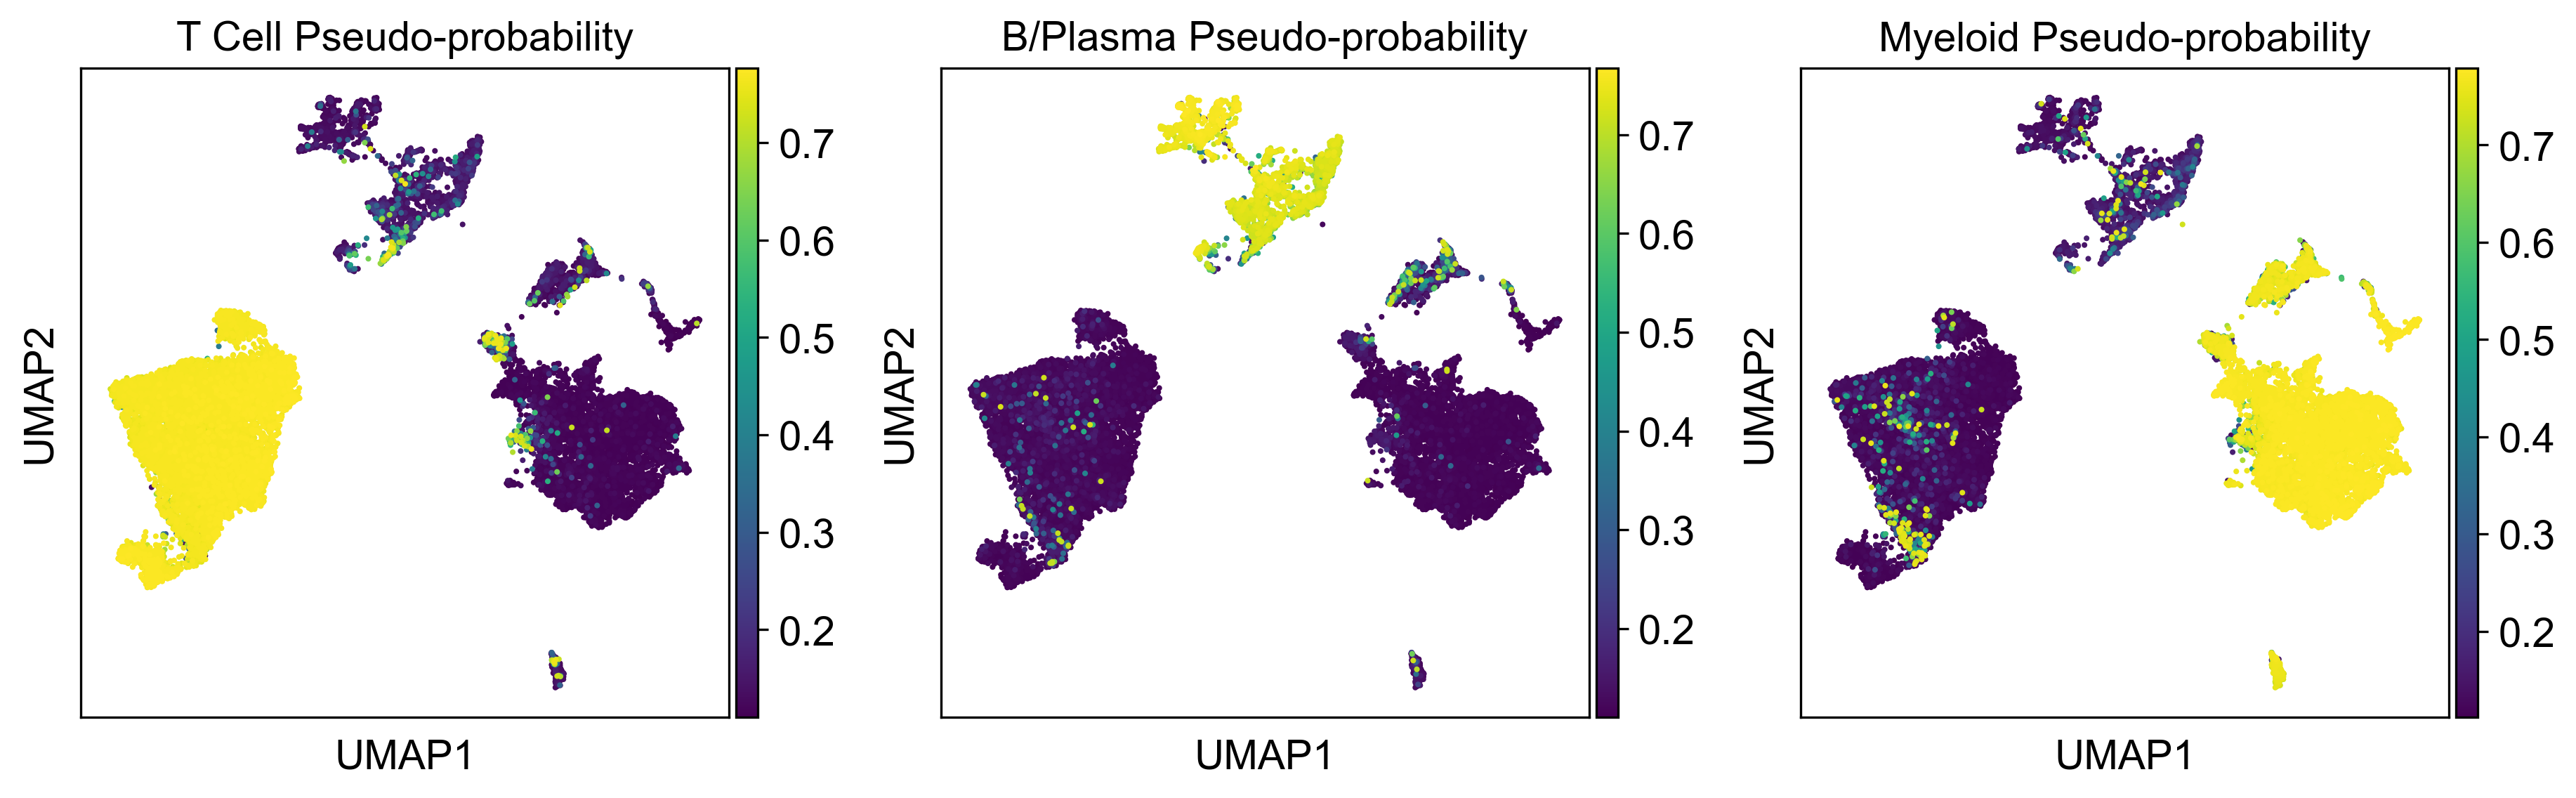

In [19]:
prob_cols = [x for x in annotated_adata_orig.obs.columns.tolist() if "Pseudo-probability" in x]
sc.pl.umap(annotated_adata_orig,color=prob_cols,size=15,save="pseudo.pdf",palette="magma")
ct2 = []
for x in annotated_adata_orig.obs["cell_type"]:
    if "T " in x:
        ct2.append("T Cell")
    elif "mDC" in x or "cDC" in x or "pDC" in x:
        ct2.append("Myeloid")
    elif "mono" in x.lower():
        ct2.append("Myeloid")
    elif "TAM" in x:
        ct2.append("Myeloid")
    elif "B " in x:
        ct2.append("B/Plasma")
    elif "NK" in x:
        ct2.append("T Cell")
    elif "Th" in x:
        ct2.append("T Cell")
    elif "Mast" in x:
        ct2.append("Myeloid")
    else:
        ct2.append(x)
annotated_adata_orig.obs["coarse_cell_type_3class"] = ct2



/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/cegli

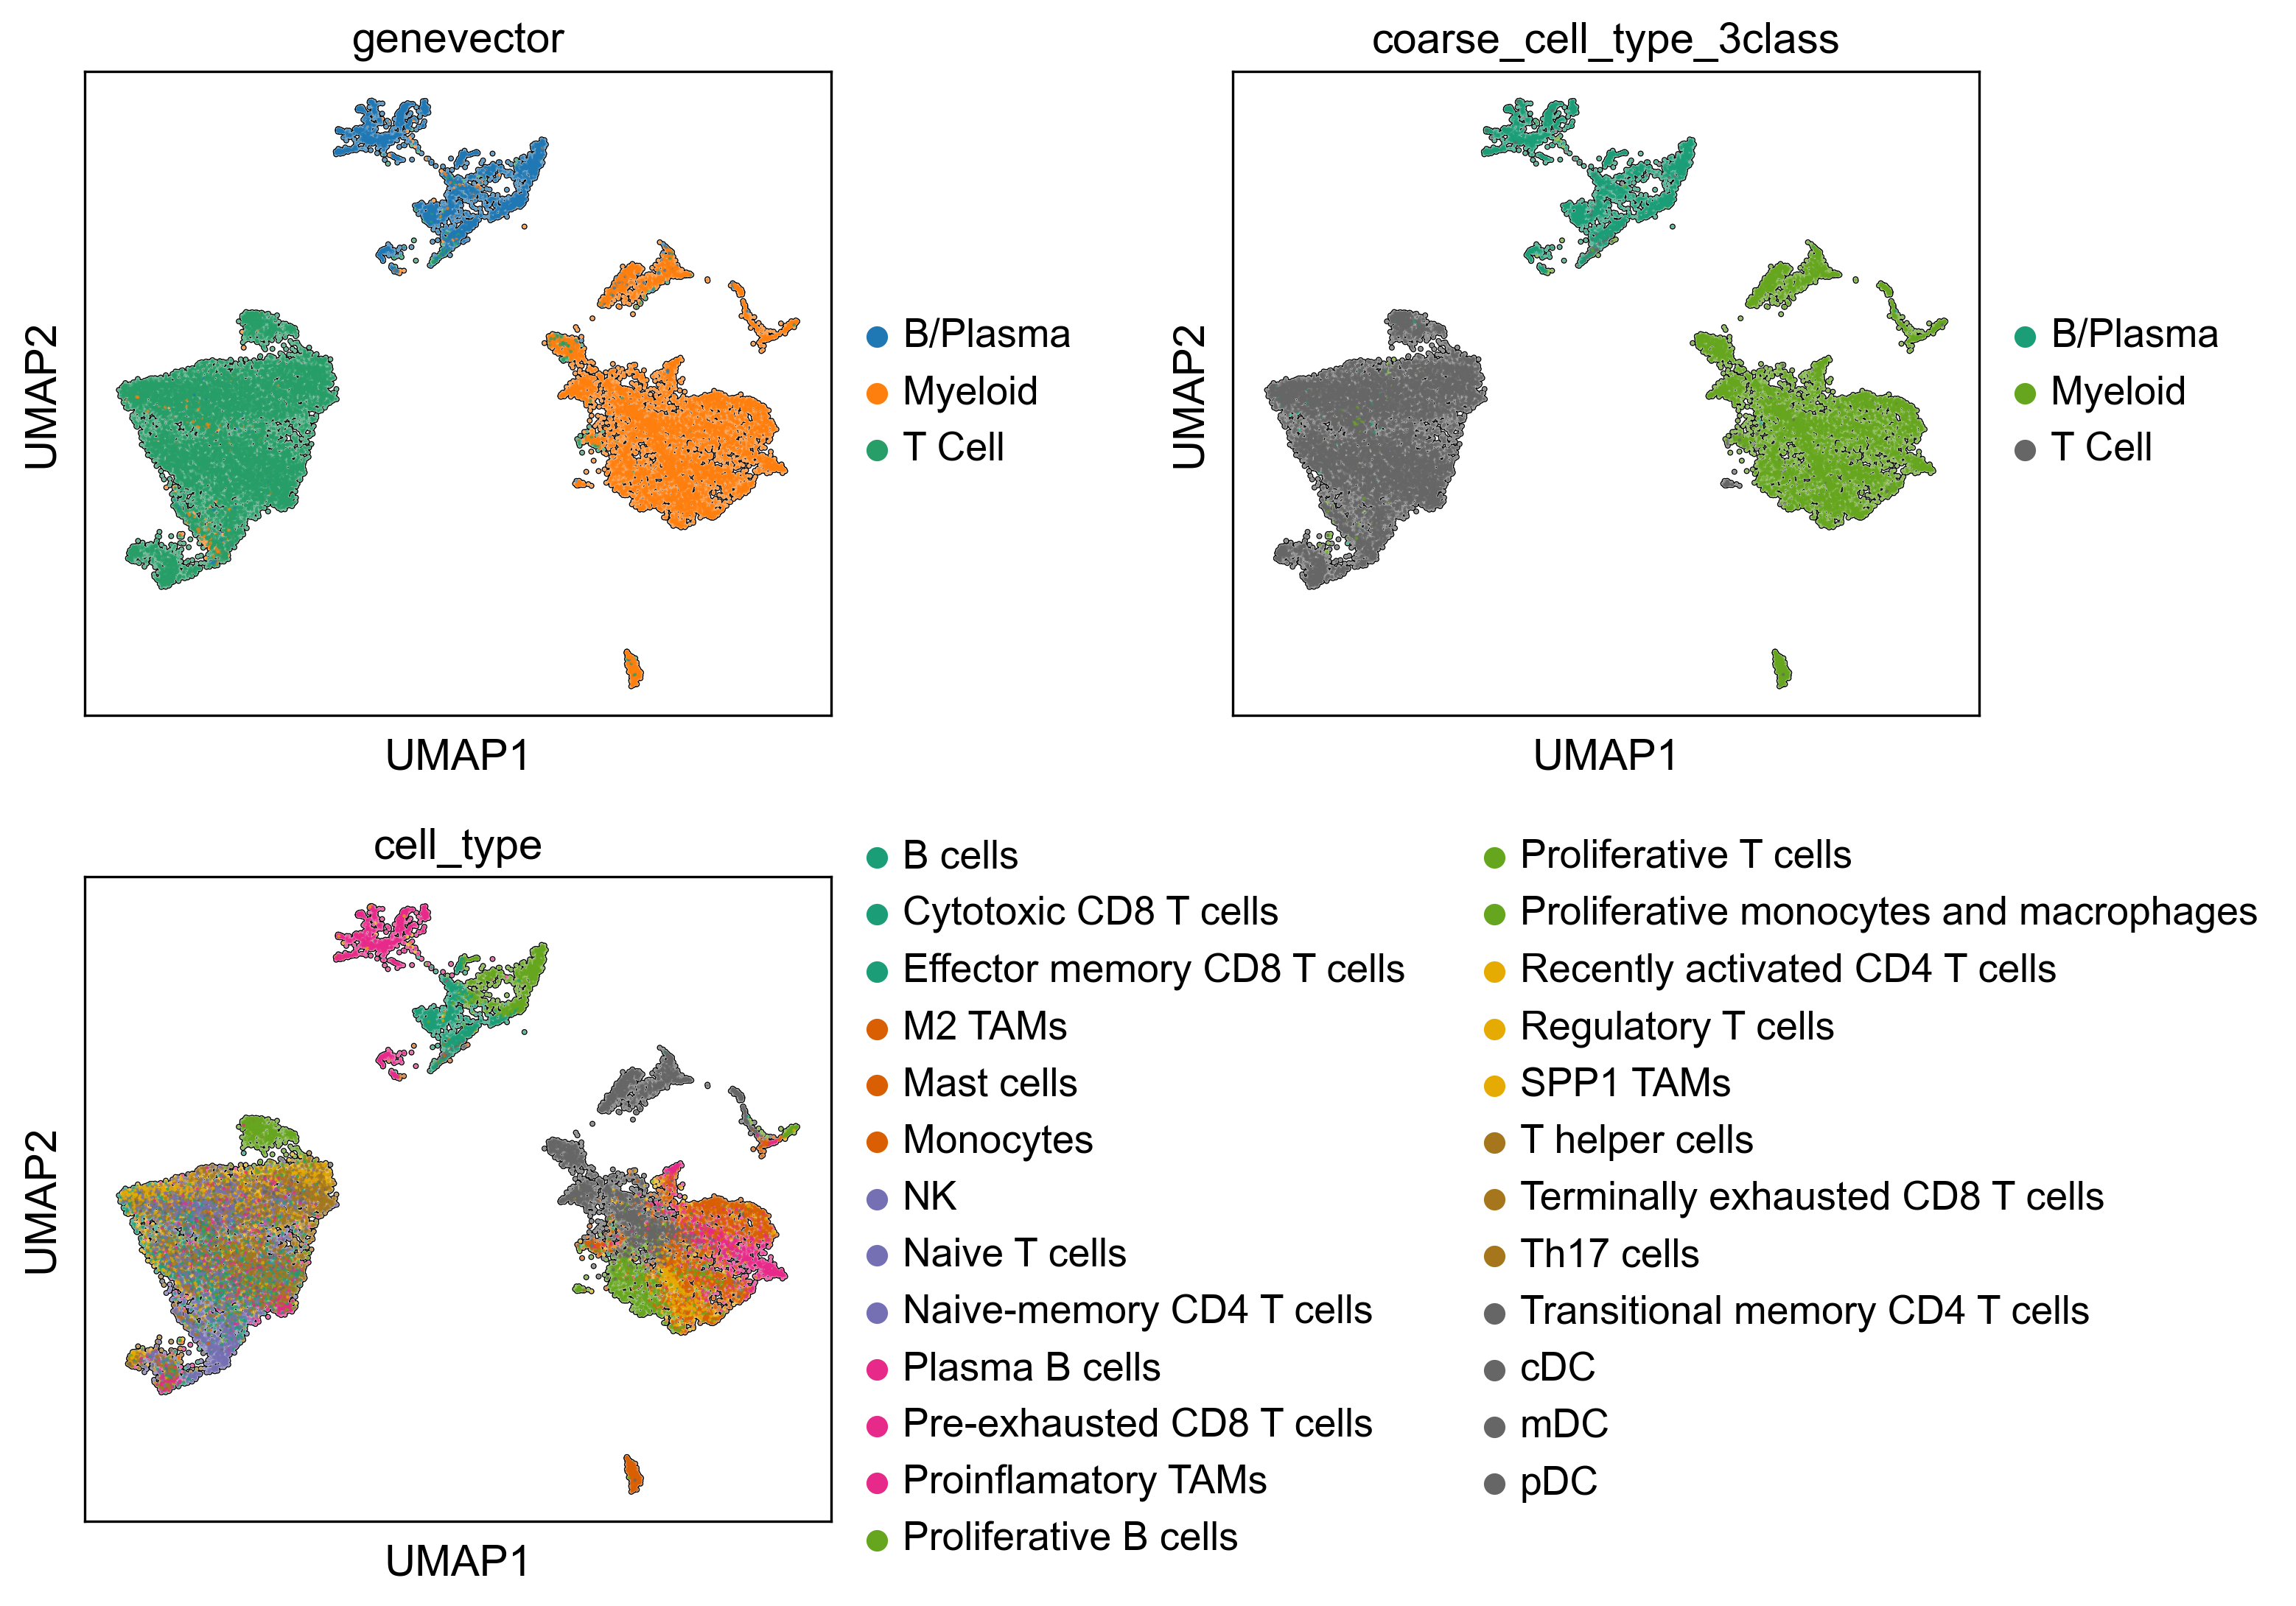

In [20]:
sc.pl.umap(annotated_adata_orig,color=["genevector","coarse_cell_type_3class","cell_type"],
           ncols=2,wspace=0.4,s=5,add_outline=True, save="tica.pdf")

In [21]:
import matplotlib
matplotlib.rcParams['svg.fonttype'] = "none"
import seaborn as sns
sns.set(font_scale=1.1)
def plot_cm(y_true, y_pred, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm_perc = pd.DataFrame(cm_perc, index=np.unique(y_true), columns=np.unique(y_true))
    cm_perc.index.name = 'TICA Coarse Cell Type'
    cm_perc.columns.name = 'GeneVector'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', ax=ax,annot_kws={"size": 12})

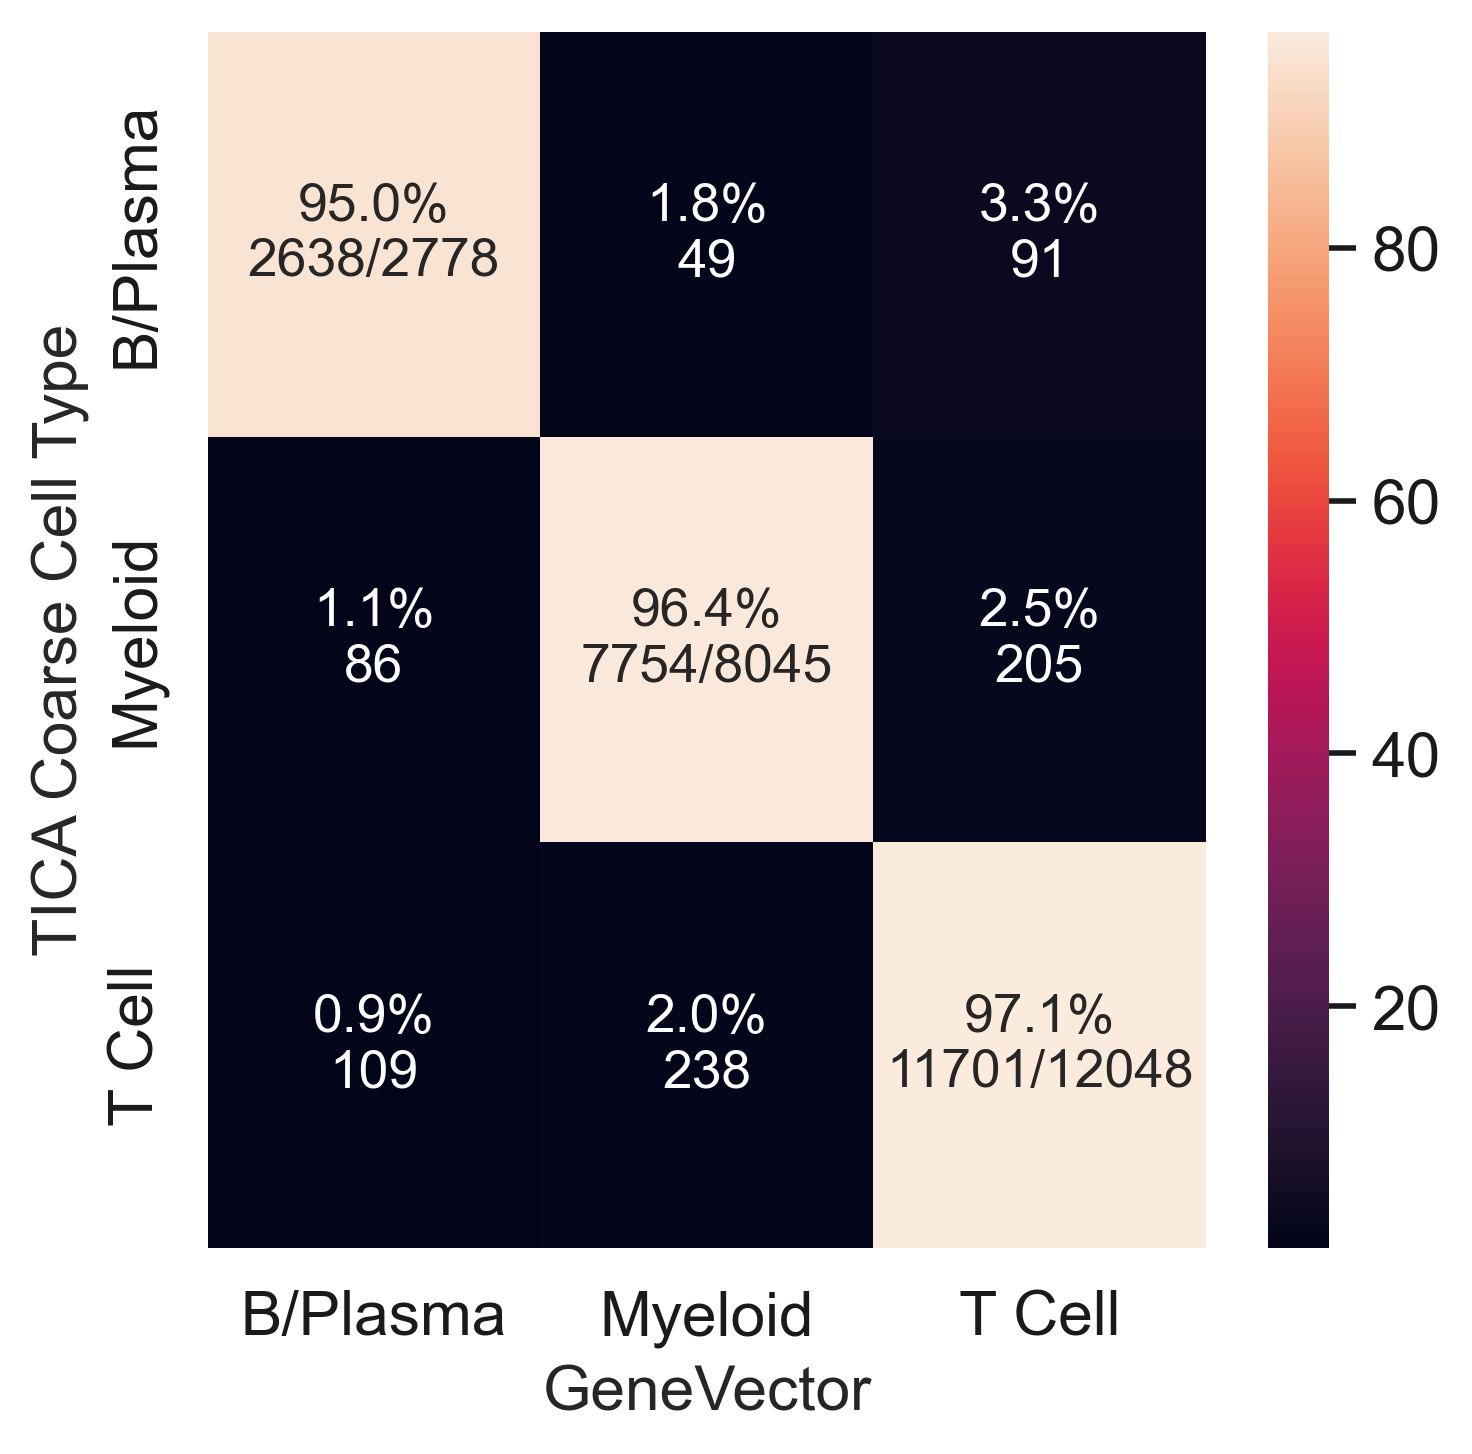

In [27]:
gv_ct_orig = annotated_adata_orig.obs["genevector"].tolist()
tica_ct_orig = annotated_adata_orig.obs["coarse_cell_type_3class"].tolist()
plot_cm(tica_ct_orig,gv_ct_orig)
df = annotated_adata_orig.obs[["genevector",
              "T Cell Pseudo-probability",
              "Myeloid Pseudo-probability",
              "B/Plasma Pseudo-probability"]]

/Users/ceglian/gvenv/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


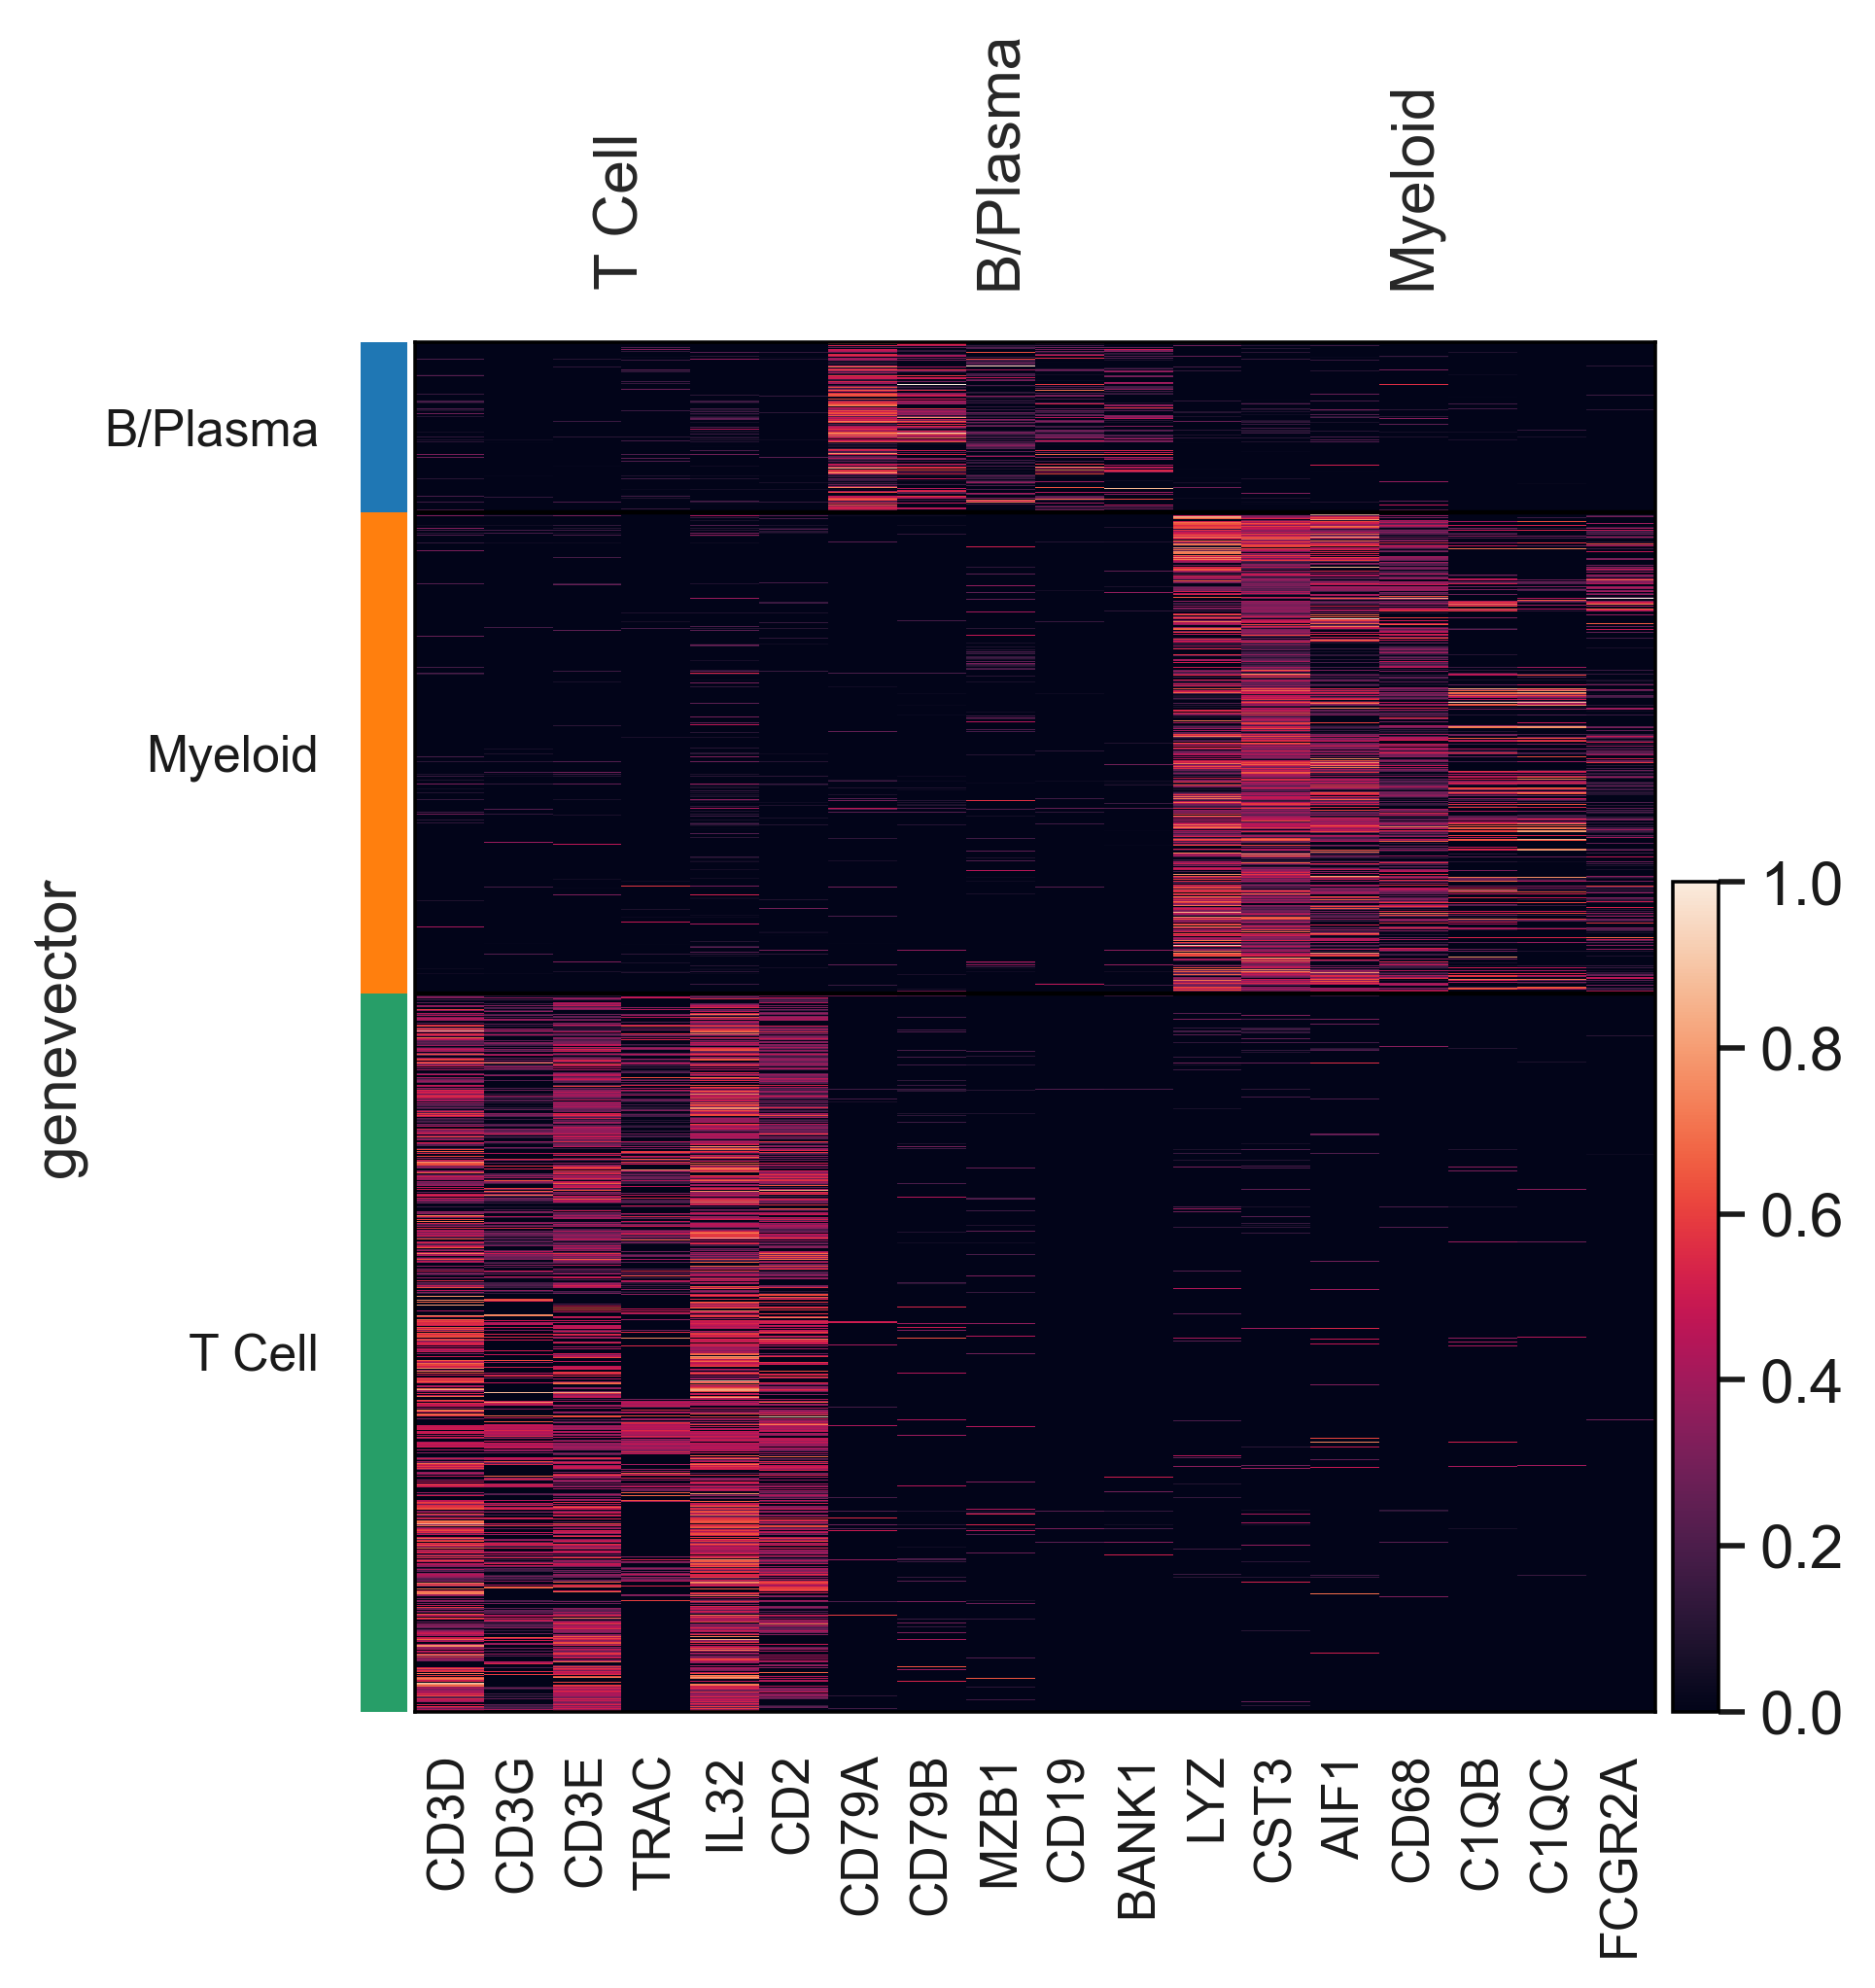

In [31]:
sc.pl.heatmap(sub,markers_orig,groupby="genevector",save="tica.pdf",standard_scale="var")